# Аналитика для Яндекс.Афиши

Задача: <u><i>помочь маркетологам оптимизировать маркетинговые затраты.</i></u>

Представлены данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Содержание

[**1. Загрузка данных и подготовка к анализу.**](#1)

[**2. Построение отчётов и рассчёт метрик.**](#2)

[**2.1 Продукт**](#21)

[2.1.1 Сколько людей пользуются в день, неделю, месяц?](#211)

[2.1.2 Сколько сессий в день?](#212)

[2.1.3 Сколько длится одна сессия?](#213)

[2.1.4 Как часто люди возвращаются?](#214)

[**2.2 Продажи**](#22)

[2.2.1 Когда люди начинают покупать?](#221)

[2.2.2 Сколько раз покупают за период?](#222)

[2.2.3 Какой средний чек?](#223)

[2.2.4 Сколько денег приносят? (LTV)](#224)

[**2.3 Маркетинг**](#23)

[2.3.1 Сколько денег потратили: всего, на каждый источник, по времени?](#231)

[2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?](#232)

[2.3.3 На сколько окупились расходы? (ROI)](#233)

[**3. Графики временных различий метрик: по устройствам и по рекламным источникам?**](#3)

[3.1 Длина сессии за период](#31)

[3.2 Суммарная прибыль за период](#32)

[3.3 Всего пользователей за период](#33)

[**4. Выводы**](#4)

## 1. Загрузка данных и подготовка к анализу. <a class='anchor' id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')

In [2]:
visits = pd.read_csv('datasets/visits_log.csv', index_col=0)
orders = pd.read_csv('datasets/orders_log.csv', index_col=0)
costs = pd.read_csv('datasets/costs.csv', index_col=0)

Приведем названия столбцов к нижнему регистру и заменим пробелы:

In [3]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [4]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

Изменим в датафрейме costs поле 'dt' на более читаемое 'date':

In [5]:
costs.columns = ['source_id', 'date', 'costs']

Приведем к правильным форматам поля с датами:

In [6]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['date'] = pd.to_datetime(costs['date'])

Проверим общую информацию по каждому датафрейму:

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


Таблица <u>*visits*</u> (лог сервера с информацией о посещениях сайта):
- **device** — категория устройства пользователя
- **end_ts** — дата и время окончания сессии
- **source_id** — идентификатор рекламного источника, из которого пришел пользователь
- **start_ts** — дата и время начала сессии
- **uid** — уникальный идентификатор пользователя

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


Таблица <u>*orders*</u> (информация о заказах):
- **buy_ts** — дата и время заказа
- **revenue**  — выручка Яндекс.Афиши с этого заказа
- **uid** — уникальный id пользователя, который сделал заказ

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 79.4 KB


Таблица <u>*costs*</u> (информация о затратах на маркетинг):
- **source_id** — идентификатор рекламного источника
- **date** — дата
- **costs** — затраты на этот рекламный источник в этот день

## 2. Построение отчётов и рассчёт метрик. <a class='anchor' id='2'></a>

### 2.1 Продукт <a class='anchor' id='21'></a>

#### 2.1.1 Сколько людей пользуются в день, неделю, месяц? <a class='anchor' id='211'></a>

Выделим в отдельные столбцы год, месяц, неделю и полную дату:

In [10]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Определим количество уникальных пользователей в день:

In [11]:
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).reset_index()
int(dau_total['uid'].mean())

907

В среднем ресурс посещают 907 уникальных посетителей каждый день.

In [12]:
def visits_dynamic(df, col_name, title):
    plt.figure(figsize=(18,4))
    plt.title(title)
    sns.lineplot(data=df,x=col_name,y='uid')
    plt.ylabel('Посетителей, чел.')
    plt.xlabel('Дата');

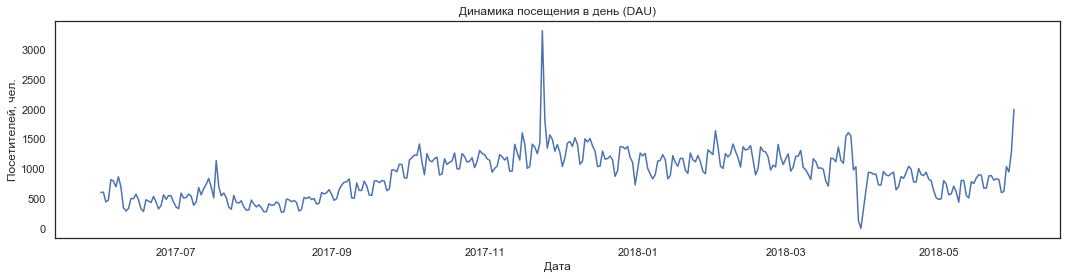

In [13]:
visits_dynamic(dau_total, 'session_date','Динамика посещения в день (DAU)')

<a class='anchor' id='edit1'></a>
- Отмечаются пики посещений после июля 2017 года, и после них плавная просадка.
- Отдельно стоит выделить пик в декабря - вероятно предновогодний ажиотаж.
- После нового года посещения стабилизируются с провалом к апрелю 2018 года.
- На июнь 2018 наблюдается всплеск активности.

Определим количество уникальных пользователей в неделю:

In [14]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).reset_index()
int(wau_total['uid'].mean())

5716

В среднем ресурс посещают 5716 уникальных посетителей в неделю.

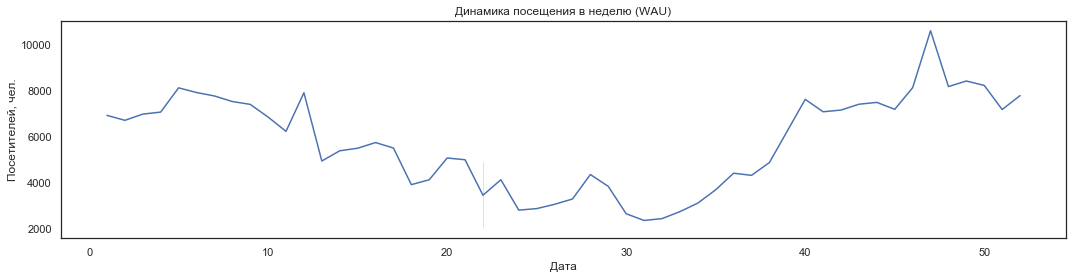

In [15]:
visits_dynamic(wau_total, 'session_week','Динамика посещения в неделю (WAU)')

Определим количество уникальных пользователей в месяц:

In [16]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).reset_index()
int(mau_total['uid'].mean())

23228

В среднем ресурс посещают 23228 уникальных посетителей в месяц.

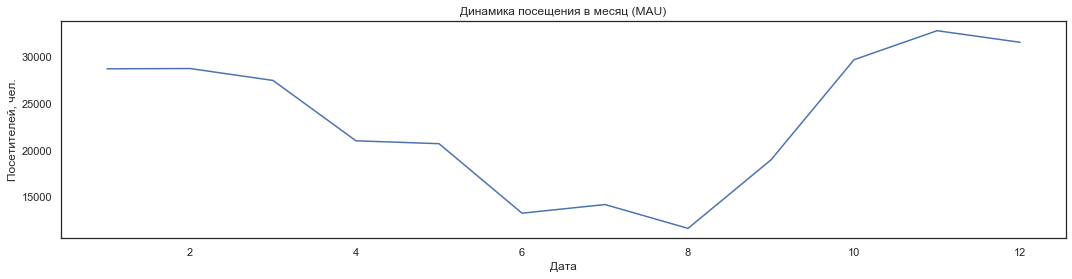

In [17]:
visits_dynamic(mau_total, 'session_month','Динамика посещения в месяц (MAU)')

В динамике по месяцам можно заподозрить сезонность, но данных одного года слишком мало для выводов.

#### 2.1.2 Сколько сессий в день? <a class='anchor' id='212'></a>

In [18]:
sessions_per_user = visits.groupby(['session_year','session_date']).agg({'uid':['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['session_per_user'] = sessions_per_user['n_sessions']/sessions_per_user['n_users']
sessions_per_user['session_per_user'].mean()

1.0821696440039723

В среднем на одного пользователя приходится одна сессия в день.

#### 2.1.3 Сколько длится одна сессия? <a class='anchor' id='213'></a>

Вычислим среднюю продолжительность сессии:

In [19]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

В среднем одна сессия длится 644 секунды (почти 11 минут). Однако рассмотрим распределение:

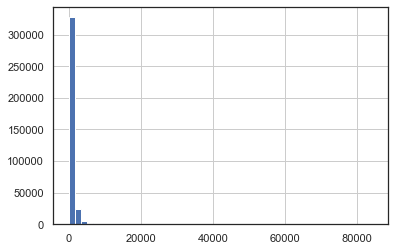

In [20]:
visits['session_duration_sec'].hist(bins=50);

Посольку распредление не является нормальным, то вместо среднего арифметического значения извлечем моду:

In [21]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Чаще всего пользовательская сессия длится 60 секунд (или 1 минуту), по всей видимости это связано с тем, что большинство посетилелей переходят по ссылке с других сайтов, оформляют заказ и выходят.

#### 2.1.4 Как часто люди возвращаются? <a class='anchor' id='214'></a>

Сформируем когорты:

In [22]:
first_activity = visits.groupby('uid')['start_ts'].min()
first_activity.name = 'first_activity'
first_activity.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_activity, dtype: datetime64[ns]

In [23]:
visits = visits.join(first_activity, on='uid')

In [24]:
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

Вычислим lifetime для каждой когорты:

In [25]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Сгруппиируем в когорты:

In [26]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Найдем исходное количество пользователей в когорте:

In [27]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам:

In [28]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

Рассчитаем retention rate:

In [29]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Построим сводную таблицу и тепловую карту: <a class='anchor' id='edit2'></a>

In [30]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

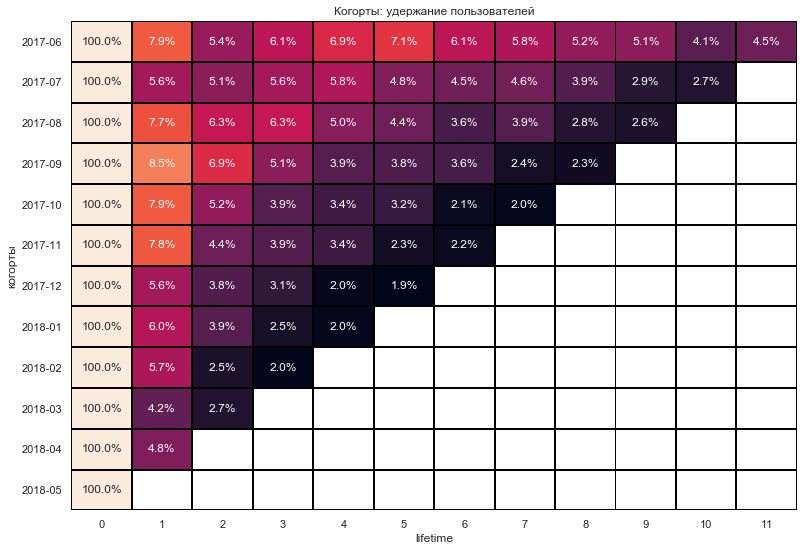

In [31]:
plt.figure(figsize=(13,9))
plt.title('Когорты: удержание пользователей')
g = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmax=.11, cbar=False)
g.set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.xlabel('lifetime')
plt.ylabel('когорты');

Во всех когортах заметен сильный спад посещений на 1 месяц жизни. Когорта июня 2017 года показала увеличение показателя на 5 месяц жизни (может были какие-то акции для преданных пользователей?). Так же стоит отметить чуть более повышенные показатели возврата пользователей на 1 и 2 месяцы жизни в августовской и сентябрьской когортах.

### 2.2 Продажи <a class='anchor' id='22'></a>

#### 2.2.1 Когда люди начинают покупать? <a class='anchor' id='221'></a>

In [32]:
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order_date'

In [33]:
orders = orders.join(first_order, on='uid')

In [34]:
orders.head()

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [35]:
visits_to_orders = pd.merge(visits, orders, on='uid')

Определим разницу во времени между первым визитом и первой покупкой. Извлечем количество секунд и округлим до часов: <a class='anchor' id='edit3'></a>

In [36]:
visits_to_orders['date_difference'] = visits_to_orders['first_order_date'] - visits_to_orders['first_activity']
visits_to_orders['date_difference_hour'] = visits_to_orders['date_difference'].dt.seconds.div(3600).astype('int')

In [37]:
diff_cohorts = visits_to_orders.groupby(['first_activity_month', 'cohort_lifetime']).agg({'date_difference_hour':'median'}).reset_index()
diff_cohorts['date_difference_hour'] = diff_cohorts['date_difference_hour'].astype('int')

In [38]:
diff_pivot = diff_cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='date_difference_hour')

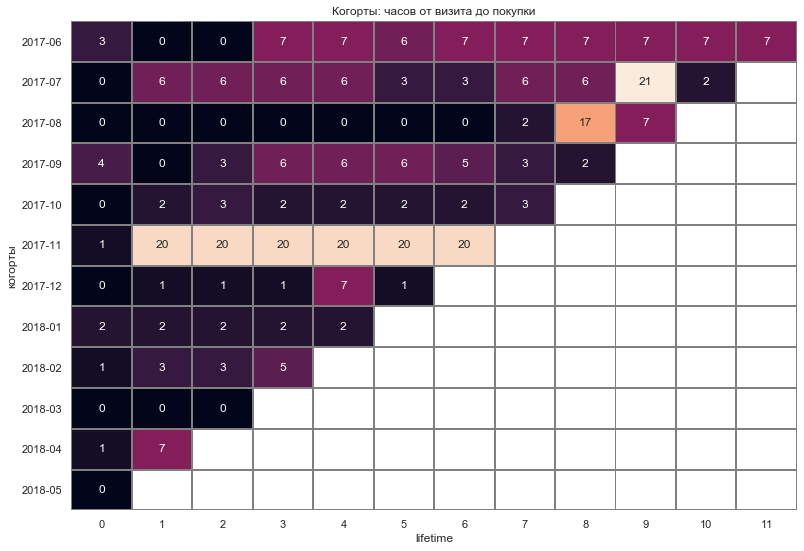

In [39]:
plt.figure(figsize=(13,9))
plt.title('Когорты: часов от визита до покупки')
g = sns.heatmap(diff_pivot, annot=True, linewidths=1, linecolor='gray', cbar=False)
g.set_yticklabels(diff_pivot.index.strftime('%Y-%m'))
plt.xlabel('lifetime')
plt.ylabel('когорты');

- Согласно среднему количеству часов между первым визитом и первой покупкой половина когорт совершает покупку мгновенно или через час (полагаю это из-за того, что из других порталов ведут гиперссылки на агрегатор).
- Можно отметить поведение июньской когорты как стабильное начиная с 3 месяца - люди начинают покупать в среднем через 7 часов.
- Отдельно выделим когорту ноября 2017 года, начиная с 1 месяца покупки совершаются в среднем через 20 часов после первого визита.
- Так же августовская когорта несколько 7 месяцев подряд совершала покупки моментально.

In [40]:
visits_to_orders['date_difference_hour'].median()

5.0

В среднем по всем когортам люди начинают делать первые покупки через 5 часов после первого посещения сайта.

#### 2.2.2 Сколько раз покупают за период? <a class='anchor' id='222'></a>

Извлечем первые и последующие месяцы покупки:

In [41]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Сформируем сводную таблицу:

In [42]:
orders_pivot = orders.pivot_table(index='first_order_month', columns='order_month', values='uid', aggfunc='count')
orders_pivot.fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2354,177,174,226,292,218,276,174,212,153,96,86,
2017-07-01,,2186,100,120,104,72,82,61,50,58,24,53,
2017-08-01,,,1533,108,100,81,85,62,49,78,46,46,
2017-09-01,,,,2933,219,161,164,67,109,108,56,61,
2017-10-01,,,,,4964,314,162,122,129,103,86,125,
2017-11-01,,,,,,4813,397,182,211,136,59,102,
2017-12-01,,,,,,,5052,270,202,179,86,105,
2018-01-01,,,,,,,,3783,224,159,64,78,
2018-02-01,,,,,,,,,4095,222,83,70,


- После первого месяца количество покупок в каждой когорте сильно снижается. Более менее активно заказывающими оказываются когорты июня 2017, далее наблюдается провал (похоже из-за сезонности - большая часть людей в отпусках). 
- А затем можно отметить активность начиная с октября, новый сезон, все вернулись из отпусков, не исключено что сайт пестрит особыми предложениями по условиям.
- Так же отметим что в марте 2018 наблюдается провал по количеству заказов по всем когортам.

#### 2.2.3 Какой средний чек? <a class='anchor' id='223'></a>

Определим средний чек (как сумма покупок относится к числу покупок).

Сгруппируем заказы по когортам: <a class='ancor' id='edit4'></a>

In [43]:
orders_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

Определим как с течением времени изменяется средний чек (отношение суммы покупок к количеству покупок):

In [44]:
orders_by_cohorts['revenue_per_user'] = (orders_by_cohorts['revenue'] / orders_by_cohorts['uid'])
revenue_per_user_pivot = orders_by_cohorts.pivot_table(index='first_order_month', columns='order_month', 
                                          values='revenue_per_user', aggfunc='mean')

Для наглядности оформим тепловую карту:

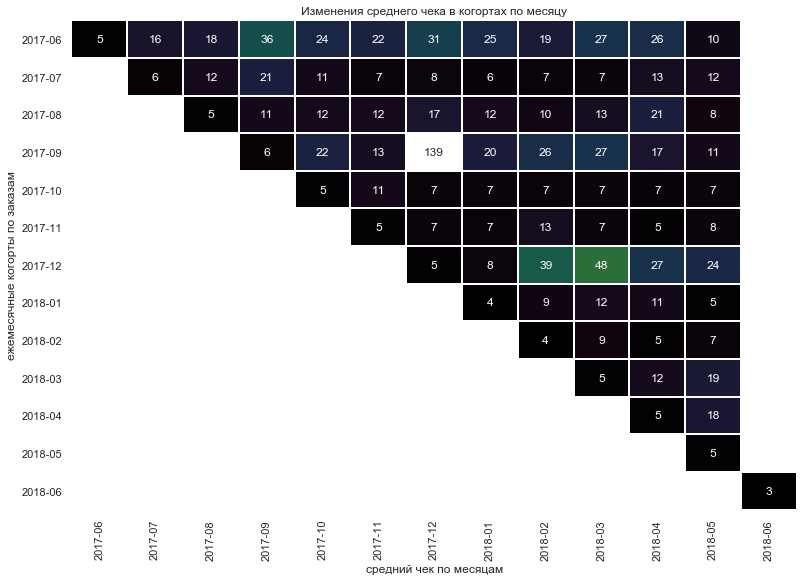

In [45]:
plt.figure(figsize=(13,9))
plt.title('Изменения среднего чека в когортах по месяцу')
rpu = sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.0f', cbar=False, linewidths=1, 
            linecolor='white', cmap="cubehelix")
rpu.set_yticklabels(revenue_per_user_pivot.index.strftime('%Y-%m'))
rpu.set_xticklabels(revenue_per_user_pivot.columns.strftime('%Y-%m'))
plt.xlabel('средний чек по месяцам')
plt.ylabel('ежемесячные когорты по заказам');

Среди всех когорт неожиданно показала себя когорта заказов от сентября в декабре, есть две версии:

- предположительно имеет место предновогодний ажиотаж (массовые удорожания билетов), однако странно почему остальные когорты не показали сильно прибыли по среднему чеку; 
- был концерт очень популярной группы, или яркого события с дорогими билетами (сентябрьская когорта оказалась лояльной к нашему сервису и предпочла купить билеты у нас).

Так же после этого всплеска по сентябрьской когорте наблюдается более высокие хотя и нисходящие показатели. По всей видимости произошли изменения в маркетинговой политике и/или интерфейс стал удобнее.

Так же выделяется декабрьская когорта, которая стала активной с февраля и показала относительно высокие средние чеки.

#### 2.2.4 Сколько денег приносят? (LTV) <a class='anchor' id='224'></a>

Посчитаем количество новых покупателей за месяц:

In [46]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','n_buyers']

Обратимся к датафрейму orders_by_cohorts и используем сумму выручки:

In [47]:
orders_by_cohorts = orders_by_cohorts.reset_index()

LTV - накопительная выручка когорты в пересчете на людей. Сформируем таблицу с данными о том, сколько людей первый раз совершили покупку каждый месяц:

In [48]:
report = pd.merge(orders_by_cohorts, cohort_sizes, on='first_order_month')

In [49]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Для дальнейших рассчетов нам требуется величина маржинальности, но она явно не указана в условии. Предположим что сервис Афиша работает без наценки, продает билеты по себестоимости, а значит маржинальность примем за единицу. Поскольку валовую прибыль мы приравняли к общей так как маржинальность единица, то можем сразу вычислить параметр ltv: <a class='anchor' id='edit5'></a>

In [50]:
report['ltv'] = report['revenue'] / report ['n_buyers']

In [51]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

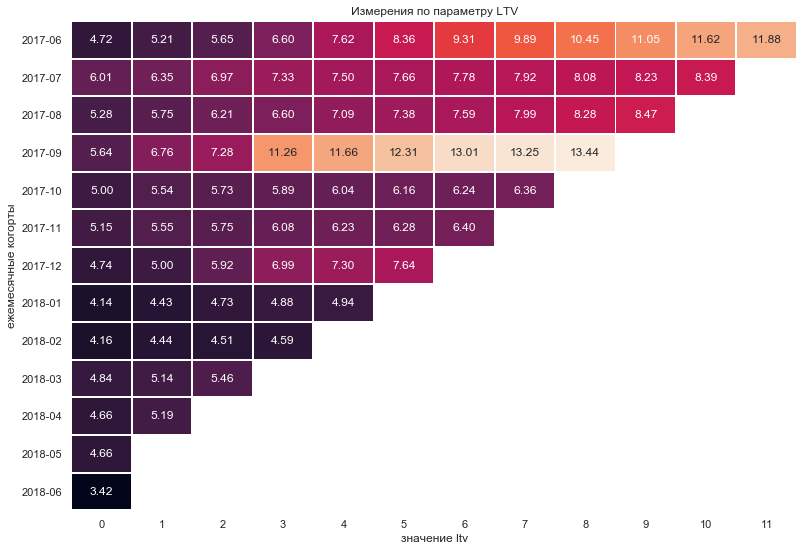

In [52]:
plt.figure(figsize=(13,9))
plt.title('Измерения по параметру LTV')
ltv_gr = sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', cbar=False, linewidths=1,
            linecolor='white')
ltv_gr.set_yticklabels(revenue_per_user_pivot.index.strftime('%Y-%m'))
plt.xlabel('значение ltv')
plt.ylabel('ежемесячные когорты');

- Самыми прибыльними для сервиса являются июньская и сентябрьская когорты.
- Наименее прибыльные когорты января и февраля 2018 года (вероятно играет роль сезонность, как следствие меньше интересных предложений, как следствие меньший интерес к ресурсу).

### 2.3. Маркетинг <a class='anchor' id='23'></a>

#### 2.3.1 Сколько денег потратили: всего, на каждый источник, по времени? <a class='anchor' id='231'></a>

- Потрачено на маркетинг всего:

In [53]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [54]:
costs['costs'].sum().round(2)

329131.62

Всего за весь период на маркетинг потрачено 329131.62 у.е.

In [55]:
print('ROMI = {:.2%}'.format(orders['revenue'].sum() / costs['costs'].sum()))

ROMI = 76.58%


Суммарный возврат на инвестиции за период составил 76.58%

- Потрачено на каждый источник привлечения:

In [56]:
source_costs = costs.groupby('source_id').agg({'costs':'sum'})
source_costs

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


- Потрачено на маркетинг всего по времени (ежемесячно):

In [57]:
costs['monthly_costs'] = costs['date'].astype('datetime64[M]')

Составим график ежедневных затрат на маркетинг: <a class='anchor' id='edit6'></a>

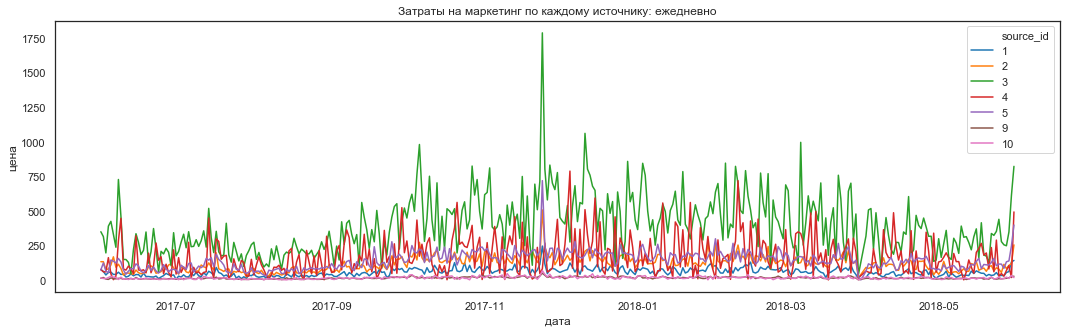

In [58]:
plt.figure(figsize=(18,5))
plt.title('Затраты на маркетинг по каждому источнику: ежедневно')
mc = sns.lineplot(data=costs, x='date', hue='source_id', y='costs', legend='full', palette='tab10', ci=None)
plt.xlabel('дата')
plt.ylabel('цена');

Составим график ежемесячных затрат на маркетинг:

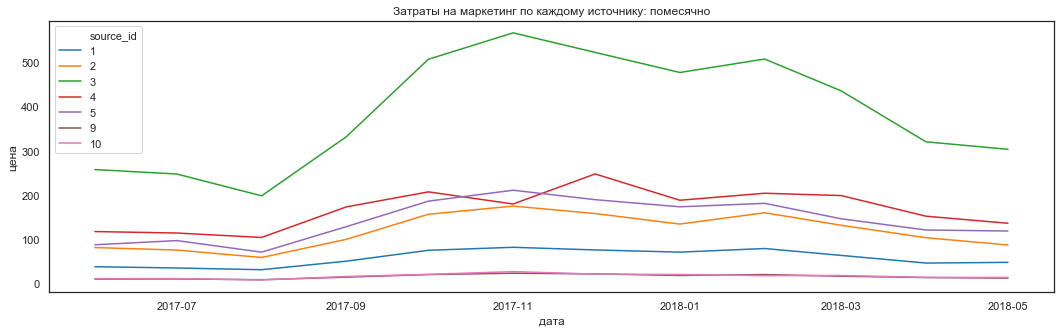

In [59]:
plt.figure(figsize=(18,5))
plt.title('Затраты на маркетинг по каждому источнику: помесячно')
mc = sns.lineplot(data=costs, x='monthly_costs', hue='source_id', y='costs', legend='full', palette='tab10', ci=None)
plt.xlabel('дата')
plt.ylabel('цена');

- Самым затратным является источник №4.
- Также можно выделить вторую по стоимости группу из источников №2 №4 №5.
- По всем графикам заметна сезонность - затраты по всем источникам были снижены в августе 2017 года, в январе 2018 года и в апреле 2018 года.

##### 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника? <a class='anchor' id='232'></a>

Определим количество уникальных покупателей, пришедших от каждого источника: <a class='anchor' id='edit7'></a>

In [60]:
visits_to_orders.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity,first_activity_month,activity_month,cohort_lifetime,buy_ts,revenue,first_order_date,date_difference,date_difference_hour
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,00:20:00,0
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,00:20:00,0
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,15:11:00,15
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,15:11:00,15
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,15:11:00,15


In [61]:
visits_by_source = visits_to_orders.groupby('source_id').agg({'uid':'nunique'}).reset_index()
visits_by_source

,source_id,uid
0,1,7138
1,2,7305
2,3,13846
3,4,14253
4,5,10156
5,7,1
6,9,2793
7,10,1773


In [62]:
source_costs

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [63]:
cac_by_source = pd.merge(source_costs, visits_by_source, on='source_id')
cac_by_source.columns = ['source_id','source_costs', 'users_by_source']
cac_by_source

,source_id,source_costs,users_by_source
0,1,20833.27,7138
1,2,42806.04,7305
2,3,141321.63,13846
3,4,61073.60,14253
4,5,51757.10,10156
5,9,5517.49,2793
6,10,5822.49,1773


Рассчитаем метрику CAC как отношение суммарных затрат на источник к количеству пользователей, привлеченных этим источником:

In [64]:
cac_by_source['cac'] = cac_by_source['source_costs'] / cac_by_source['users_by_source']
cac_by_source.sort_values(by='cac', ascending=False)

,source_id,source_costs,users_by_source,cac
2,3,141321.63,13846,10.206676
1,2,42806.04,7305,5.859828
4,5,51757.10,10156,5.096209
3,4,61073.60,14253,4.284965
6,10,5822.49,1773,3.283976
0,1,20833.27,7138,2.918642
5,9,5517.49,2793,1.975471


Самый дорогой источник привлечения - это источник №3. Его работа обходится сервису в 10.2 у.е. за пользователя. В топе так же источник №2 - с ценой 5.85 у.е. за пользователя и источник №5 - с ценой 5.0 у.е. за пользователя.

In [65]:
cac_by_source.sort_values(by='users_by_source', ascending=False)

,source_id,source_costs,users_by_source,cac
3,4,61073.60,14253,4.284965
2,3,141321.63,13846,10.206676
4,5,51757.10,10156,5.096209
1,2,42806.04,7305,5.859828
0,1,20833.27,7138,2.918642
5,9,5517.49,2793,1.975471
6,10,5822.49,1773,3.283976


Однако больше всего клиентов привлек источник №4 - 14253 уникальных покупателей за годовой период. На втором месте источник №3 по количеству покупателей.

##### 2.3.3 На сколько окупились расходы? (ROI) <a class='anchor' id='233'></a>

In [66]:
cohort_sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_order_month  13 non-null     datetime64[ns]
 1   n_buyers           13 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 336.0 bytes


In [67]:
costs

,source_id,date,costs,monthly_costs
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [68]:
monthly_costs = costs.groupby('monthly_costs').agg({'costs':'sum'})
monthly_costs

,costs
monthly_costs,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


In [69]:
cac_count = pd.merge(cohort_sizes, monthly_costs, left_on='first_order_month', right_on='monthly_costs')
cac_count.columns = ['first_order_month', 'n_buyers', 'monthly_costs']

Вычислим CAC для когорт - найдем отношение расходов за месяц к количеству новых пользователей в когорте:

In [70]:
cac_count['cac'] = (cac_count['monthly_costs']/cac_count['n_buyers']).round(2)

In [71]:
report['first_order_month'] = pd.to_datetime(report['first_order_month'])
report_new = pd.merge(report, cac_count, on=['first_order_month','n_buyers'])
report_new.head()

,first_order_month,order_month,revenue,uid,revenue_per_user,n_buyers,age,ltv,monthly_costs,cac
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,2023,0,4.724414,18015.0,8.91
1,2017-06-01,2017-07-01,981.82,61,16.095410,2023,1,0.485329,18015.0,8.91
2,2017-06-01,2017-08-01,885.34,50,17.706800,2023,2,0.437637,18015.0,8.91
3,2017-06-01,2017-09-01,1931.30,54,35.764815,2023,3,0.954671,18015.0,8.91
4,2017-06-01,2017-10-01,2068.58,88,23.506591,2023,4,1.022531,18015.0,8.91


Рассчитаем ROMI по когортам:

In [72]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.63,0.74,0.86,0.94,1.04,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.83,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.24,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.5,0.5,0.51,,,,,,,,


- Июньская когорта окупилась на 6 месяц (ROMI = 1.04)
- Сентябрьская когорта окупилась на 3 месяц (ROMI = 1.19)
- остальные когорты до сих пор не окупили себя полностью, однако стремятся к этому.

Рассчитаем среднюю когорту по ROMI:

In [73]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.540754
1     0.581931
2     0.630987
3     0.719658
4     0.782825
5     0.859750
6     0.896631
7     0.969732
8     1.053600
9     0.964026
10    1.094088
11    1.333247
dtype: float64

В среднем ожидается что когорты начинают окупаться к 8-10 месяцу.

Рассчитаем LTV по источникам привлечения: <a class='ancor' id='edit8'></a>

In [74]:
source_ltv = visits_to_orders.groupby('source_id').agg({'revenue':'sum', 'uid':'nunique'})
source_ltv['ltv'] = source_ltv['revenue'] / source_ltv['uid']
source_ltv.sort_values(by='ltv', ascending=False).round(2).loc[:,['ltv']]

,ltv
source_id,
2,361.15
1,321.97
5,116.33
4,34.85
3,21.43
9,13.01
10,8.25
7,1.22


- Согласно метрике LTV источник привлечения №2 оказался самым прибыльным - **361.15 у.е.** на пользователя.
- Не сильно отстает источник №1 с показателем **321.97 у.е.** на пользователя.
- На третьем месте источник №5 с показателем **116.33 у.е.** на пользователя.

### 3 Графики временных различий метрик: по устройствам и по рекламным источникам? <a class='anchor' id='3'></a>

#### 3.1 Длина сессии за период: <a class='anchor' id='31'></a>

<u><i>По устройствам:</i></u>

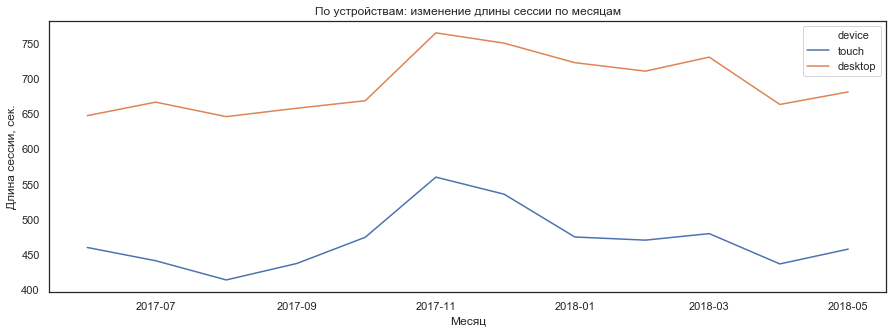

In [75]:
plt.figure(figsize=(15,5))
plt.title('По устройствам: изменение длины сессии по месяцам')
sns.lineplot(data=visits, hue='device', x='activity_month', y='session_duration_sec', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Длина сессии, сек.');

По длине сессии заметно что с настольных копьютеров пользователи проводят больше времени на сайте.
Отметим так же просадку по обоим типам устройств в августе 2017 (по всей видимости сезонный фактор).
Так же отметим два подъема - в ноябре 2017 (ищем заранее на новогодние мероприятия) и в марте 2018 (либо много значимых мероприятий либо обновления). Примечательно что следом в апреле идет провал по времени проведенному на сайте.

<u><i>По источникам:</i></u>

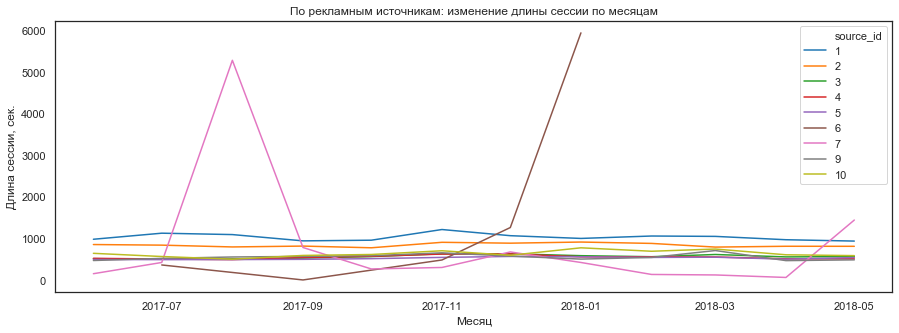

In [76]:
plt.figure(figsize=(15,5))
plt.title('По рекламным источникам: изменение длины сессии по месяцам')
sns.lineplot(data=visits, legend='full', palette='tab10', hue='source_id', x='activity_month', y='session_duration_sec', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Длина сессии, сек.');

Источник №2 обеспечил высокую длину сессии в августе 2017 года, а затем упал, правда к маю 2018 года снова набирает обороты.

Источник №6 начиная с ноября по январь показал очень высокое привлечние по времени проведенному на сайте.

#### 3.2 Суммарная прибыль за период: <a class='anchor' id='32'></a>

<u><i>По устройствам:</i></u>

In [77]:
revenue_by_device = visits_to_orders.groupby(['device','activity_month']).agg({'revenue':'sum'}).reset_index()

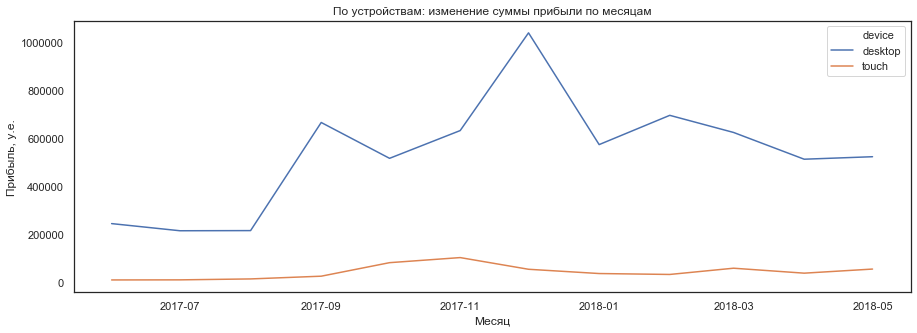

In [78]:
plt.figure(figsize=(15,5))
plt.title('По устройствам: изменение суммы прибыли по месяцам')
sns.lineplot(data=revenue_by_device, hue='device', x='activity_month', y='revenue', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Прибыль, у.е.');

Настольные устройства по прибыли так же опережают мобильные, и показывают высокую динамику и эластичность по прибыли. Мобильные устройства ведут себя более менее спокойно и предсказуемо.

<u><i>По источникам:</i></u>

In [79]:
revenue_by_source = visits_to_orders.groupby(['source_id','activity_month']).agg({'revenue':'sum'}).reset_index()

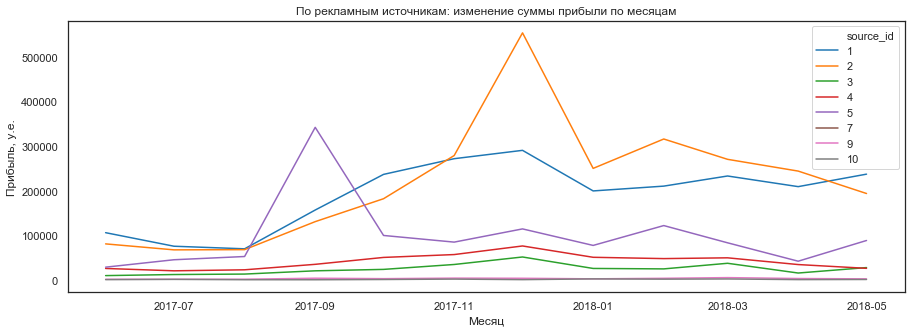

In [80]:
plt.figure(figsize=(15,5))
plt.title('По рекламным источникам: изменение суммы прибыли по месяцам')
sns.lineplot(data=revenue_by_source, legend='full', palette='tab10', hue='source_id', x='activity_month', y='revenue', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Прибыль, у.е.');

В сентябре 2017 большую прибыль принес источник №5.

Начиная с августа 2017 года рост по прибыли показывал источник №1. Далее следовала небольшая просадка в январе (посленовогодняя просадка), и последующий рост. Так что этот источник хорошо себя показывает.

Планомерный вклад в прибыльность показывает источник №2 начиная в августа 2017. В декабре этот источник выстрелил и далее не сильно сдал позиции.

#### 3.3 Всего пользователей за период: <a class='anchor' id='33'></a>

<u><i>По устройствам:</i></u>

In [81]:
users_by_device = visits_to_orders.groupby(['device','activity_month']).agg({'uid':'nunique'}).reset_index()

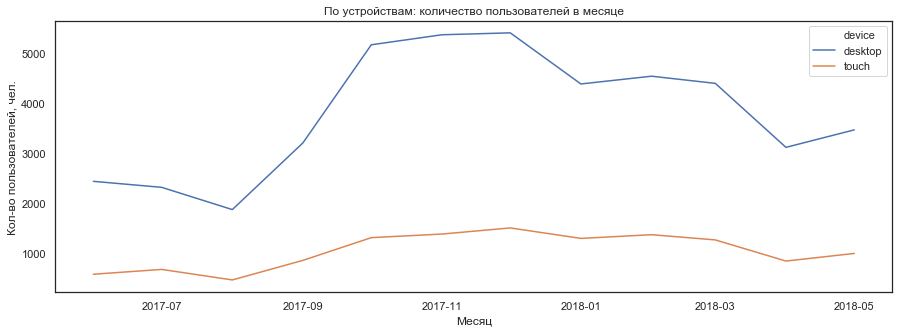

In [82]:
plt.figure(figsize=(15,5))
plt.title('По устройствам: количество пользователей в месяце')
sns.lineplot(data=users_by_device, hue='device', x='activity_month', y='uid', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Кол-во пользователей, чел.');

В августе начинается подъем по количеству посещений на обоих типах устройств. Похоже на посещение сильно влияет опять же сезонность: с похолоданиями и окончанием сезона отпусков резко возрастает интерес к посещению различных мероприятий. P.S. было бы интересно отследить кореляцию посещений к погоде.

<u><i>По источникам:</i></u>

In [83]:
users_by_source = visits_to_orders.groupby(['source_id','activity_month']).agg({'uid':'nunique'}).reset_index()

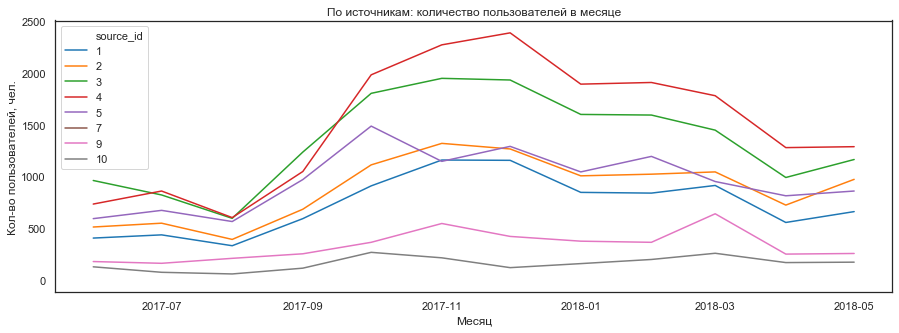

In [84]:
plt.figure(figsize=(15,5))
plt.title('По источникам: количество пользователей в месяце')
sns.lineplot(data=users_by_source, legend='full', palette='tab10', hue='source_id', x='activity_month', y='uid', ci=None)
plt.xlabel('Месяц')
plt.ylabel('Кол-во пользователей, чел.');

По количеству привлеченных пользователей выделяется источник №4 и ему не сильно уступает источник №3.

Во вторую группу стоит объединить иточники №№ 2, 5 и 1.

## 4. Выводы. <a class='anchor' id='4'></a>

В среднем ресурс посещают **907** уникальных посетителей каждый день, **5716** уникальных посетителей в неделю и **23228** уникальных посетителей в месяц.

- Отмечаются пики посещений после июля 2017 года, и после них плавная просадка.
- Отдельно стоит выделить пик в декабря - вероятно предновогодний ажиотаж.
- После нового года посещения стабилизируются с провалом к апрелю 2018 года.
- На июнь 2018 наблюдается всплеск активности.

В динамике по месяцам можно заподозрить сезонность, но данных одного года слишком мало для выводов.

В среднем на одного пользователя приходится одна сессия в день.

Чаще всего пользовательская сессия длится 60 секунд (или 1 минуту), по всей видимости это связано с тем, что большинство посетилелей переходят по ссылке с других сайтов, оформляют заказ и выходят.

- Во всех когортах заметен сильный спад посещений на 1 месяц жизни. 
- Когорта июня 2017 года показала увеличение показателя на 5 месяц жизни (может были какие-то акции для преданных пользователей?). 
- Так же стоит отметить чуть более повышенные показатели возврата пользователей на 1 и 2 месяцы жизни в августовской и сентябрьской когортах.

Разница между первым визитом и первой покупкой:

- Согласно среднему количеству часов между первым визитом и первой покупкой половина когорт совершает покупку мгновенно или через час (полагаю это из-за того, что из других порталов ведут гиперссылки на агрегатор).
- Можно отметить поведение июньской когорты как стабильное начиная с 3 месяца - люди начинают покупать в среднем через 7 часов.
- Отдельно выделим когорту ноября 2017 года, начиная с 1 месяца покупки совершаются в среднем через 20 часов после первого визита.
- Так же августовская когорта несколько 7 месяцев подряд совершала покупки моментально.

Количество покупок:

- После первого месяца количество покупок в каждой когорте сильно снижается. Более менее активно заказывающими оказываются когорты июня 2017, далее наблюдается провал (похоже из-за сезонности - большая часть людей в отпусках). 
- А затем можно отметить активность начиная с октября, новый сезон, все вернулись из отпусков, не исключено что сайт пестрит особыми предложениями по условиям.
- Так же отметим что в марте 2018 наблюдается провал по количеству заказов по всем когортам.

Среди всех когорт неожиданно показала себя когорта сентябрь 2017 по заказам в декабре, есть две версии:

- предположительно имеет место предновогодний ажиотаж (массовые удорожания билетов), однако странно почему остальные когорты не показали сильно прибыли по среднему чеку; 
- был концерт очень популярной группы, или яркого события с дорогими билетами (сентябрьская когорта оказалась лояльной к нашему сервису и предпочла купить билеты у нас).

Так же после этого всплеска по сентябрьской когорте наблюдается более высокие хотя и нисходящие показатели. По всей видимости произошли изменения в маркетинговой политике и/или интерфейс стал удобнее.

Так же выделяется декабрьская когорта, которая стала активной с февраля и показала высокие средние чеки.

- Самыми прибыльними для сервиса являются июньская и сентябрьская когорты.
- Наименее прибыльные когорты января и февраля 2018 года (вероятно играет роль сезонность, как следствие меньше интересных предложений, как следствие меньший интерес к ресурсу).

Анализ источников привлечения:

- Самым затратным является источник №4.
- Также можно выделить вторую по стоимости группу из источников №2 №4 №5.
- По всем графикам заметна сезонность - затраты по всем источникам были снижены в августе 2017 года, в январе 2018 года и в апреле 2018 года.

Всего за весь период на маркетинг потрачено **329131.62** у.е.

Суммарный возврат на инвестиции за период составил 76.58%

Самый дорогой источник привлечения - это источник №3. Его работа обходится сервису в **10.2** у.е. за пользователя. В топе так же источник №2 - с ценой **5.85** у.е. за пользователя и источник №5 - с ценой **5.0** у.е. за пользователя.

Однако больше всего клиентов привлек источник №4 - **14253** уникальных покупателей за годовой период. На втором месте источник №3 по количеству покупателей.

- Июньская когорта окупилась на 6 месяц (ROMI = 1.04)
- Сентябрьская когорта окупилась на 3 месяц (ROMI = 1.19)
- остальные когорты до сих пор не окупили себя полностью, однако стремятся к этому.

В среднем ожидаемо что когорты начинают окупаться к 8-10 месяцу.

По длине сессии заметно что с настольных копьютеров пользователи проводят больше времени на сайте.
Отметим так же просадку по обоим типам устройств в августе 2017 (по всей видимости сезонный фактор).
Так же отметим два подъема - в ноябре 2017 (ищем заранее на новогодние мероприятия) и в марте 2018 (либо много значимых мероприятий либо обновления). Примечательно что следом в апреле идет провал по времени проведенному на сайте.

Источник №2 обеспечил высокую длину сессии в августе 2017 года, а затем упал, правда к маю 2018 года снова набирает обороты.

Источник №6 начиная с ноября по январь показал очень высокое привлечение по времени проведенному на сайте.

Настольные устройства по прибыли так же опережают мобильные, и показывают высокую динамику и эластичность по прибыли. Мобильные устройства ведут себя более менее спокойно и предсказуемо.

В сентябре 2017 большую прибыль принес источник №5.

Начиная с августа 2017 года рост по прибыли показывал источник №1. Далее следовала небольшая просадка в январе (посленовогодняя просадка), и последующий рост. Так что этот источник хорошо себя показывает.

Планомерный вклад в прибыльность показывает источник №2 начиная в августа 2017. В декабре этот источник выстрелил и далее не сильно сдал позиции.

В августе начинается подъем по количеству посещений на обоих типах устройств. Похоже на посещение сильно влияет опять же сезонность: с похолоданиями и окончанием сезона отпусков резко возрастает интерес к посещению различных мероприятий. P.S. было бы интересно отследить кореляцию посещений к погоде.

По количеству привлеченных пользователей выделяется источник №4 и ему не сильно уступает источник №3.

Во вторую группу стоит объединить иточники №№ 2, 5 и 1.

- Согласно метрике LTV источник привлечения №2 оказался самым прибыльным - **361.15 у.е.** на пользователя.
- Не сильно отстает источник №1 с показателем **321.97 у.е.** на пользователя.
- На третьем месте источник №5 с показателем **116.33 у.е.** на пользователя.